# Malware Detection - Clustering

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph

### Data processing

In [ ]:
data = pd.read_csv('./trn_data_small.csv', delimiter=';')

X = data.iloc[:, 1:-1]
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.describe()

,periodicity,duration,pkt_size,msg_count,src_ports_count,dst_port,src_spec_chars,msg_spec_chars,msg_word_entropy
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.0,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.274147,106491.640833,15755.089167,54.155833,1.0,45406.715000,0.260752,0.253457,4.715345
std,0.271415,128204.312003,42927.979898,142.733191,0.0,10941.466465,0.134735,0.170468,3.038249
min,0.006600,0.000000,111.000000,1.000000,1.0,2441.000000,0.095200,0.000000,-0.000000
25%,0.070875,16.750000,284.750000,2.000000,1.0,37789.000000,0.157900,0.179000,2.000000
50%,0.277200,10914.500000,1308.000000,8.000000,1.0,45225.000000,0.230800,0.227800,4.955250
75%,0.277200,258327.250000,7834.000000,48.000000,1.0,52874.000000,0.307700,0.285700,7.132750
max,1.000000,619200.000000,402599.000000,3592.000000,1.0,65124.000000,0.846200,1.000000,10.707400


# PCA
### Feature scaling


In [ ]:
from sklearn.preprocessing import StandardScaler

# Target 값을 제외한 모든 속성 값을 StandardScaler를 이용하여 표준 정규 분포를 가지는 값들로 변환
X_scaled = StandardScaler().fit_transform(X_train.iloc[:, :-1])
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print(X_pca.shape)

(1200, 2)


In [ ]:
# PCA 환된 데이터의 컬럼명을 각각 pca_component_1, pca_component_2로 명명
pca_columns=['pca_component_1','pca_component_2']
DF_pca = pd.DataFrame(X_pca, columns=pca_columns)
DF_pca['label']=y_train
DF_pca.head(3)

,pca_component_1,pca_component_2,label
0,-0.688649,-0.422262,0.0
1,1.087159,-0.021552,0.0
2,5.318761,0.652679,0.0


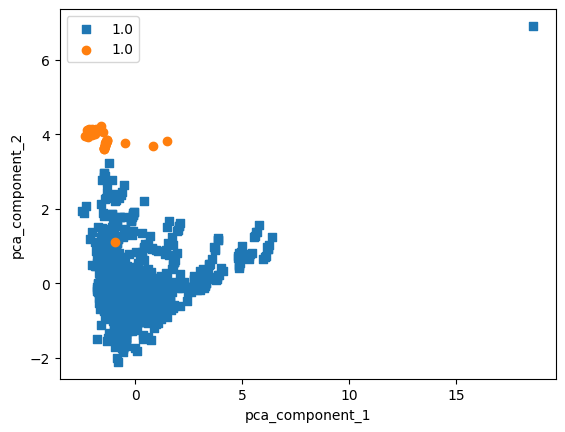

In [ ]:
markers=['s', 'o']

#pca_component_1 을 x축, pc_component_2를 y축으로 scatter plot 수행.
for i, marker in enumerate(markers):
    x_axis_data = DF_pca[DF_pca['label']==i]['pca_component_1']
    y_axis_data = DF_pca[DF_pca['label']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=y[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)

[0.34230876 0.17028537]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

rcf = RandomForestClassifier(random_state=156)
scores = cross_val_score(rcf, X_train, y_train,scoring='accuracy',cv=3)
print('원본 데이터 교차 검증 개별 정확도:',scores)
print('원본 데이터 평균 정확도:', np.mean(scores))

원본 데이터 교차 검증 개별 정확도: [1.     1.     0.9975]
원본 데이터 평균 정확도: 0.9991666666666666


In [ ]:
pca_X = DF_pca[['pca_component_1', 'pca_component_2']]
scores_pca = cross_val_score(rcf, pca_X, y_train, scoring='accuracy', cv=3 )
print('PCA 변환 데이터 교차 검증 개별 정확도:',scores_pca)
print('PCA 변환 데이터 평균 정확도:', np.mean(scores_pca))

PCA 변환 데이터 교차 검증 개별 정확도: [1.    1.    0.995]
PCA 변환 데이터 평균 정확도: 0.9983333333333334


In [ ]:
rcf.fit(X_train, y_train)
y_pred = rcf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def c_r(y_valid,y_pred):
    ax=sns.heatmap(confusion_matrix(y_pred, y_valid), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    print(classification_report(y_valid, y_pred, target_names=['Benign', 'Malware']))

              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99       283
     Malware       1.00      0.83      0.91        18

    accuracy                           0.99       301
   macro avg       0.99      0.92      0.95       301
weighted avg       0.99      0.99      0.99       301



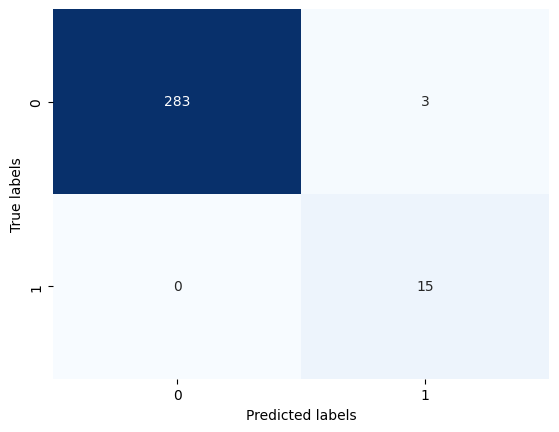

In [ ]:
c_r(y_test,y_pred)